In [ ]:
import os
import struct
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Dataset loading functions
def load_mnist_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num, 1, rows, cols)
        return images / 255.0  # Normalize to [0, 1]

def load_mnist_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

# Load MNIST dataset
data_path = '/kaggle/input/mnist-dataset/'  # Adjust this path
train_images = load_mnist_images(os.path.join(data_path, 'train-images.idx3-ubyte'))
train_labels = load_mnist_labels(os.path.join(data_path, 'train-labels.idx1-ubyte'))
test_images = load_mnist_images(os.path.join(data_path, 't10k-images.idx3-ubyte'))
test_labels = load_mnist_labels(os.path.join(data_path, 't10k-labels.idx1-ubyte'))



In [ ]:
# PyTorch Dataset with Augmentation
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


In [ ]:
# Data augmentation
transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(28, scale=(0.9, 1.1)),
])

# Create datasets and loaders
train_dataset = MNISTDataset(train_images, train_labels, transform=transform)
test_dataset = MNISTDataset(test_images, test_labels, transform=None)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



In [ ]:
# Advanced Vision Transformer Model
class AdvancedViT(nn.Module):
    def __init__(self, image_size=28, patch_size=4, num_classes=10, dim=256, depth=12, heads=8, mlp_dim=512, dropout=0.1):
        super(AdvancedViT, self).__init__()
        assert image_size % patch_size == 0, "Image size must be divisible by patch size"
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = patch_size * patch_size
        self.dim = dim

        # Patch embedding layer
        self.patch_embedding = nn.Conv2d(1, dim, kernel_size=patch_size, stride=patch_size)

        # Learnable class token and positional embeddings
        self.class_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))
        self.dropout = nn.Dropout(dropout)

        # Transformer blocks
        self.transformer = nn.ModuleList([
            TransformerBlock(dim, heads, mlp_dim, dropout) for _ in range(depth)
        ])

        # Classification head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        b = x.shape[0]
        x = self.patch_embedding(x)  # (batch, dim, num_patches)
        x = x.flatten(2).permute(0, 2, 1)  # (batch, num_patches, dim)

        # Add class token
        class_token = self.class_token.expand(b, -1, -1)
        x = torch.cat((class_token, x), dim=1)
        x += self.pos_embedding[:, :x.size(1), :]
        x = self.dropout(x)

        # Transformer
        for block in self.transformer:
            x = block(x)

        return self.mlp_head(x[:, 0])



In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = x + self.attention(x, x, x, need_weights=False)[0]
        x = self.norm1(x)
        x = x + self.mlp(x)
        x = self.norm2(x)
        return x



In [ ]:
# Train the Advanced Vision Transformer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AdvancedViT().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)

# Learning rate scheduler with warmup
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, epochs=20, steps_per_epoch=len(train_loader)
)

In [29]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Epoch [1/20], Loss: 1.2380
Epoch [2/20], Loss: 0.3352
Epoch [3/20], Loss: 0.2361
Epoch [4/20], Loss: 0.2262
Epoch [5/20], Loss: 0.2418
Epoch [6/20], Loss: 0.2884
Epoch [7/20], Loss: 0.2973
Epoch [8/20], Loss: 0.2432
Epoch [9/20], Loss: 0.2191
Epoch [10/20], Loss: 0.1897
Epoch [11/20], Loss: 0.1558
Epoch [12/20], Loss: 0.1276
Epoch [13/20], Loss: 0.1092
Epoch [14/20], Loss: 0.0849
Epoch [15/20], Loss: 0.0699
Epoch [16/20], Loss: 0.0567
Epoch [17/20], Loss: 0.0468
Epoch [18/20], Loss: 0.0410
Epoch [19/20], Loss: 0.0352
Epoch [20/20], Loss: 0.0329
Test Accuracy: 99.23%


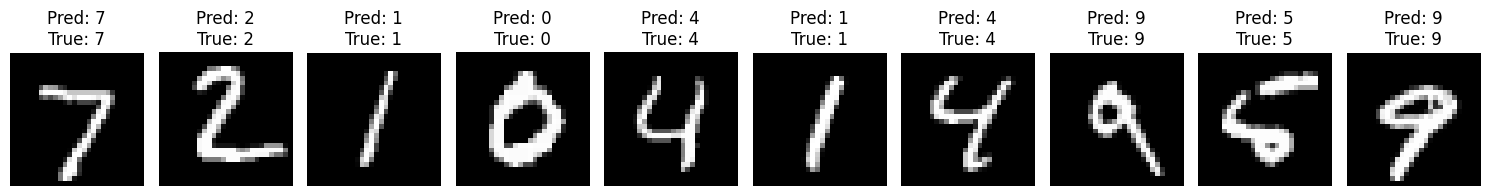

In [30]:
import matplotlib.pyplot as plt
import random

# Function to visualize predictions
def visualize_predictions(model, test_loader, device, num_images=10):
    model.eval()
    images, labels, predictions = [], [], []

    # Gather predictions
    with torch.no_grad():
        for batch_images, batch_labels in test_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            outputs = model(batch_images)
            _, preds = torch.max(outputs, 1)
            images.append(batch_images.cpu())
            labels.append(batch_labels.cpu())
            predictions.append(preds.cpu())

            # Stop once we have enough images for visualization
            if len(images) * batch_images.size(0) >= num_images:
                break

    # Combine all batches
    images = torch.cat(images)[:num_images]
    labels = torch.cat(labels)[:num_images]
    predictions = torch.cat(predictions)[:num_images]

    # Plot the images and their predictions
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(0), cmap="gray")
        ax.set_title(f"Pred: {predictions[i].item()}\nTrue: {labels[i].item()}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_predictions(model, test_loader, device)
